In [ ]:
import pandas as pd
import Numpy as np

In [9]:
data=pd.read_csv("Groceries_dataset.csv")
data

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [11]:
print(data.head())
print(data.info())
print(data.describe())

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
None
       Member_number
count   38765.000000
mean     3003.641868
std      1153.611031
min      1000.000000
25%      2002.000000
50%      3005.000000
75%      4007.000000
max      5000.000000


In [13]:
print(data.sample(5))

       Member_number        Date itemDescription
9712            3561  08-04-2014       ice cream
20593           4160  12-06-2015      rolls/buns
27727           4206  07-04-2014   domestic eggs
10939           2325  06-05-2014          onions
3179            2380  01-06-2015            pork


In [15]:
print(data.isnull().sum())

Member_number      0
Date               0
itemDescription    0
dtype: int64


In [17]:
item_counts = data['itemDescription'].value_counts()
print(item_counts.head(10))

itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64


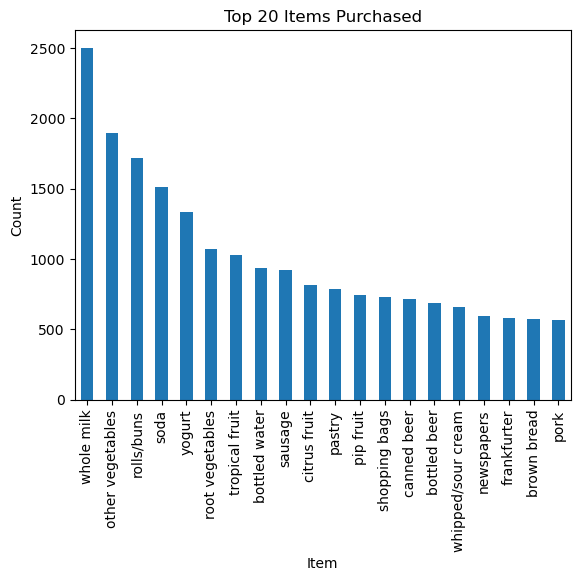

In [21]:
import matplotlib.pyplot as plt
item_counts[:20].plot(kind='bar')
plt.title('Top 20 Items Purchased')
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

In [45]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

# Encode transactions
te = TransactionEncoder()
print(te)
te_ary = te.fit(transactions).transform(transactions)
print(te_ary)
df = pd.DataFrame(te_ary, columns=te.columns)

# Apply FP-growth
min_support = 0.01  # Adjust as needed
frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
print(frequent_itemsets)

TransactionEncoder()
[]


AttributeError: 'TransactionEncoder' object has no attribute 'columns'

In [49]:
# Convert to a list of transactions
transactions = data.groupby('Customer')['Item'].apply(list).values.tolist()

# Encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

KeyError: 'Customer'